In [1]:
using Sunny, GLMakie

In [2]:
a = b = 4.05012  # Lattice constants for triangular lattice
c = 6.75214      # Spacing in the z-direction

latvecs = lattice_vectors(a, b, c, 90, 90, 120) # A 3x3 matrix of lattice vectors that
                                                 # define the conventional unit cell
positions = [[0,0,0], [1/3, 2/3, 1/4], [2/3, 1/3, 3/4]]  # Positions of atoms in fractions
                                                         # of lattice vectors
types = ["Fe", "I", "I"]
FeI2 = Crystal(latvecs, positions; types)

Crystal
HM symbol 'P -3 m 1' (164)
Lattice params a=4.05, b=4.05, c=6.752, α=90°, β=90°, γ=120°
Cell volume 95.92
Type 'Fe', Wyckoff 1a (point group '-3m.'):
   1. [0, 0, 0]
Type 'I', Wyckoff 2d (point group '3m.'):
   2. [0.3333, 0.6667, 0.25]
   3. [0.6667, 0.3333, 0.75]


In [3]:
cryst = subcrystal(FeI2, "Fe")

Crystal
HM symbol 'P -3 m 1' (164)
Lattice params a=4.05, b=4.05, c=6.752, α=90°, β=90°, γ=120°
Cell volume 95.92
Type 'Fe', Wyckoff 1a (point group '-3m.'):
   1. [0, 0, 0]


In [4]:
sys = System(cryst, (4,4,4), [SpinInfo(1,S=1)], :SUN, seed=2)

System [SU(3)]
Cell size 1, Lattice size (4, 4, 4)


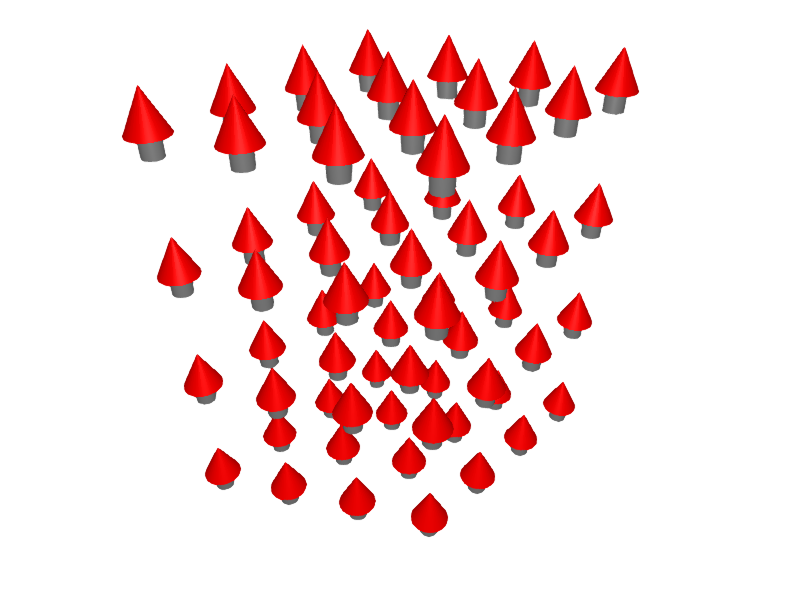

In [5]:
plot_spins(sys,arrowlength=1, linewidth=1, arrowsize=2.0)

In [6]:
print_symmetry_table(cryst, 8.0)

Atom 1
Type 'Fe', position [0, 0, 0], multiplicity 1
Allowed g-tensor: | A  0  0 |
                  | 0  A  0 |
                  | 0  0  B |
Allowed anisotropy in Stevens operators 𝒪[k,q]:
    c₁*𝒪[2,0] +
    c₂*𝒪[4,-3] + c₃*𝒪[4,0] +
    c₄*𝒪[6,-3] + c₅*𝒪[6,0] + c₆*𝒪[6,6]

Bond(1, 1, [1, 0, 0])
Distance 4.05012, coordination 6
Connects 'Fe' at [0, 0, 0] to 'Fe' at [1, 0, 0]
Allowed exchange matrix: | A  0  0 |
                         | 0  B  D |
                         | 0  D  C |

Bond(1, 1, [0, 0, 1])
Distance 6.75214, coordination 2
Connects 'Fe' at [0, 0, 0] to 'Fe' at [0, 0, 1]
Allowed exchange matrix: | A  0  0 |
                         | 0  A  0 |
                         | 0  0  B |

Bond(1, 1, [1, 2, 0])
Distance 7.01501361675086, coordination 6
Connects 'Fe' at [0, 0, 0] to 'Fe' at [1, 2, 0]
Allowed exchange matrix: | A  0  0 |
                         | 0  B  D |
                         | 0  D  C |

Bond(1, 1, [1, 0, 1])
Distance 7.8736818956572, coordination 12
Connec

In [8]:
D = 2.165
set_anisotropy!(sys, -D*𝒮[3]^2, 1)

In [9]:
Δt = 0.05/D    # Single-ion anisotropy is the strongest interaction, so 1/D is

0.023094688221709007

In [10]:
λ = 0.1        # Dimensionless magnitude of coupling to thermal bath
langevin = Langevin(Δt; kT=0, λ);
randomize_spins!(sys)

In [11]:
for kT in range(2, 0, 20_000)
    langevin.kT = kT
    step!(sys, langevin)
end

In [12]:
suggest_magnetic_supercell([[0, -1/4, 1/4]], sys.latsize)

Suggested magnetic supercell in multiples of lattice vectors:

    [1 0 0; 0 1 -2; 0 1 2]

for wavevectors [[0, -1/4, 1/4]].


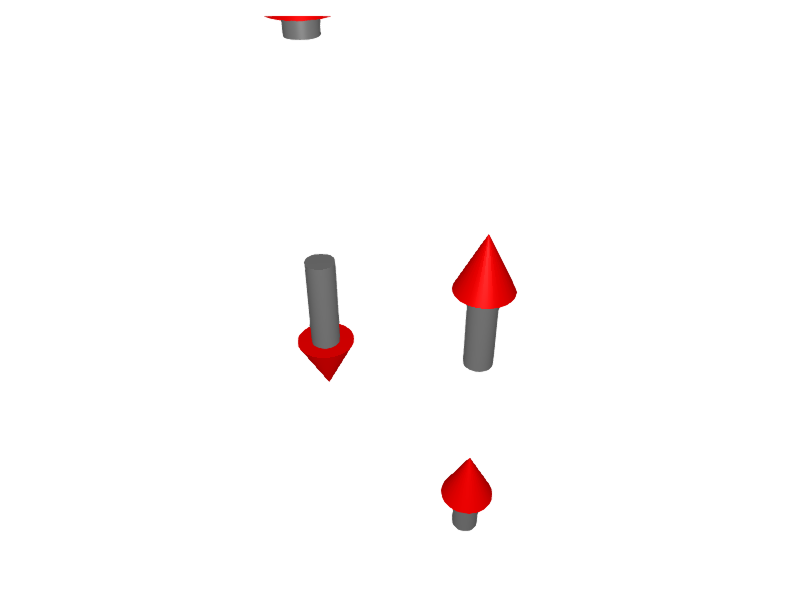

In [13]:
sys_supercell = reshape_geometry(sys, [1 0 0; 0 1 -2; 0 1 2])

langevin.kT = 0
for i in 1:10_000
    step!(sys_supercell, langevin)
end

plot_spins(sys_supercell; arrowlength=2.5, linewidth=0.75, arrowsize=1.5)

In [14]:
suggest_magnetic_supercell([[0, -1/4, 1/4]], sys.latsize)

Suggested magnetic supercell in multiples of lattice vectors:

    [1 0 0; 0 1 -2; 0 1 2]

for wavevectors [[0, -1/4, 1/4]].


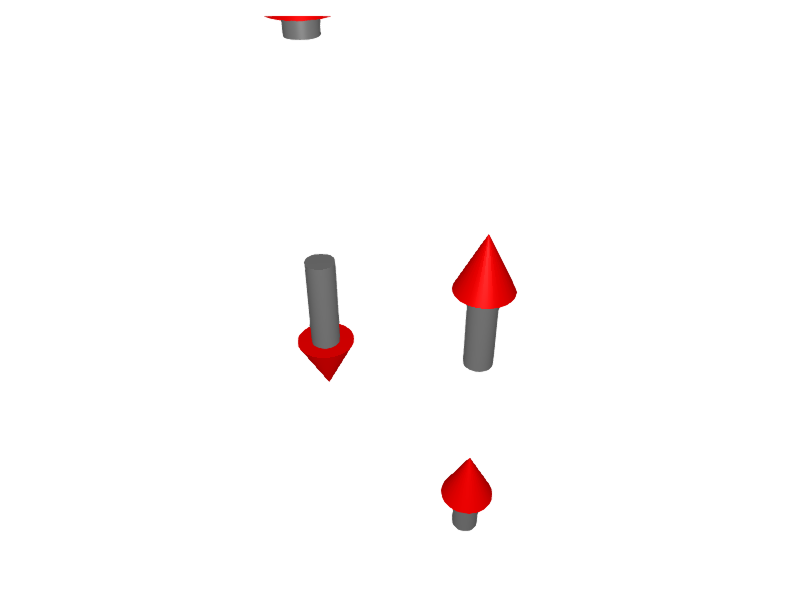

In [15]:
sys_supercell = reshape_geometry(sys, [1 0 0; 0 1 -2; 0 1 2])

langevin.kT = 0
for i in 1:10_000
    step!(sys_supercell, langevin)
end

plot_spins(sys_supercell; arrowlength=2.5, linewidth=0.75, arrowsize=1.5)

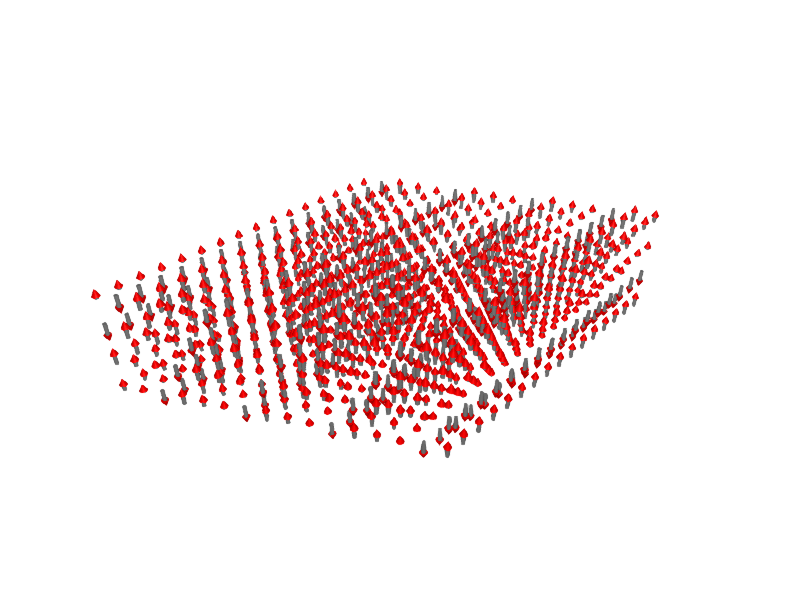

In [16]:
sys_large = resize_periodically(sys_supercell, (16,16,4))
plot_spins(sys_large; arrowlength=2.5, linewidth=0.75, arrowsize=1.5)

In [17]:
kT = 0.5 * meV_per_K     # 0.5K in units of meV
langevin.kT = kT

for _ in 1:10_000
    step!(sys_large, langevin)
end

In [18]:
sf = DynamicStructureFactor(sys; Δt=2Δt, nω=120, ωmax=7.5);

In [19]:
for _ in 1:2
    for _ in 1:1000               # Fewer steps needed in equilibrium
        step!(sys_large, langevin)
    end
    add_sample!(sf, sys_large)    # Accumulate the sample into `sf`
end

LoadError: AssertionError: `System` size not compatible with given `StructureFactor`

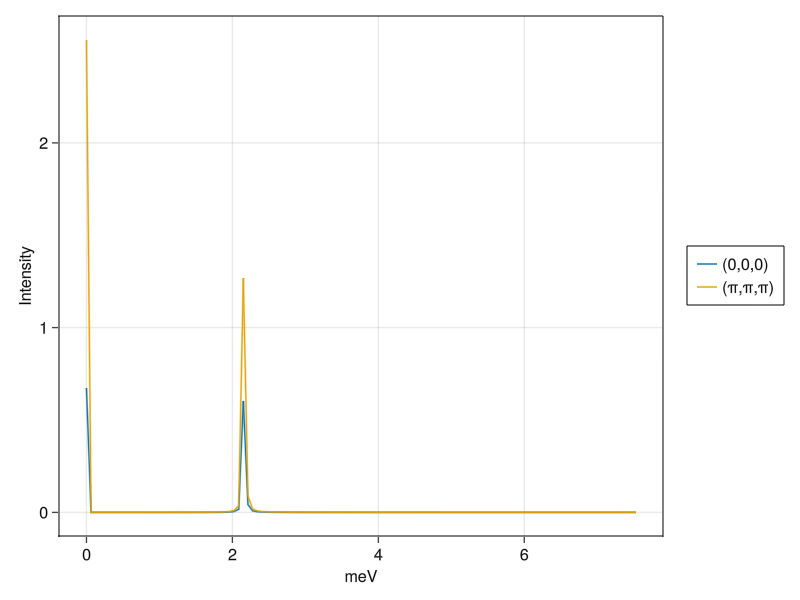

In [20]:
qs = [[0, 0, 0], [0.5, 0.5, 0]]
is = intensities(sf, qs, :trace; kT)

fig = Figure()
ax = Axis(fig[1,1]; xlabel="meV", ylabel="Intensity")
l1 = lines!(ax, ωs(sf), is[1,:])
l2 = lines!(ax, ωs(sf), is[2,:])
Legend(fig[1,2], [l1, l2], ["(0,0,0)", "(π,π,π)"])
fig

In [21]:
points = [[0,   0, 0],  # List of wave vectors that define a path
          [1,   0, 0],
          [0,   1, 0],
          [1/2, 0, 0],
          [0,   1, 0],
          [0,   0, 0]]
density = 40
path, markers = connected_path(points, density);

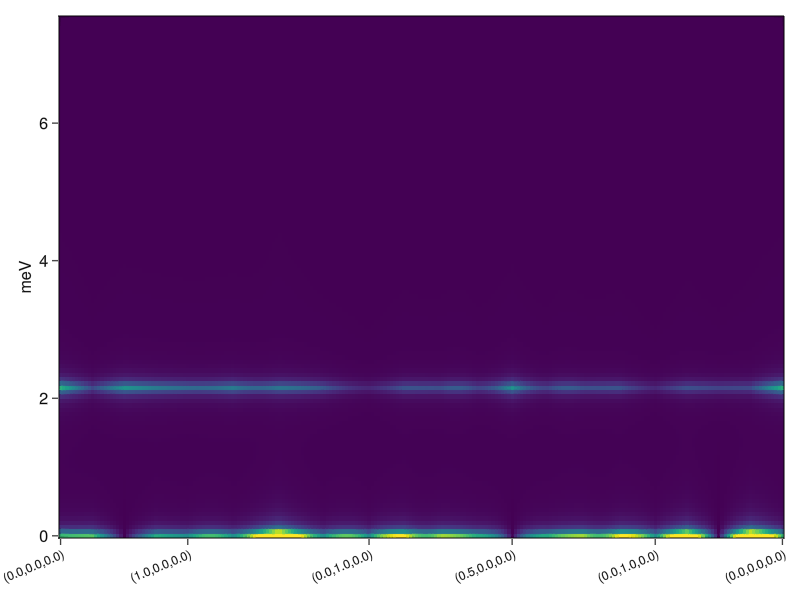

In [22]:
formfactors = [FormFactor(1, "Fe2"; g_lande=3/2)]

is = intensities(sf, path, :perp;
    interpolation = :linear,       # Interpolate between available wave vectors
    kT,                            # Temperature for intensity correction
    formfactors,                   # Form factor information
)
is = broaden_energy(sf, is, (ω, ω₀)->lorentzian(ω-ω₀, 0.06))  # Add artificial broadening

labels = ["($(p[1]),$(p[2]),$(p[3]))" for p in points]

heatmap(1:size(is,1), ωs(sf), is;
    colorrange=(0.0, 1),
    axis = (
        ylabel = "meV",
        xticks = (markers, labels),
        xticklabelrotation=π/8,
        xticklabelsize=12,
    )
)